<a href="https://colab.research.google.com/github/arvindsuresh-math/Fall-2025-Team-Big-Data/blob/main/Naive_Recommender_System_for_NEW_AirBNB_NYC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! [ -e /content ] && pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz==1.4.1
import fastbook
fastbook.setup_book()

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 39.8 MB/s eta 0:00:00
Mounted at /content/gdrive


In [2]:
from fastbook import *
from fastai.vision.all import *
from fastai.text.all import *
from fastai.collab import *
from fastai.tabular.all import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
df_rs = pd.read_parquet('/content/gdrive/MyDrive/insideairbnb/nyc/nyc_dataset_oct_17.parquet')
display(df_rs.head(1))

,id,host_id,name,description,host_is_superhost,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,minimum_nights,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price,month,price_per_person,log_price,log_price_per_person,total_reviews
0,2595,2845,Skylit Midtown Castle Sanctuary,"Beautiful, spacious skylit studio in the heart of Midtown, Manhattan. 1 BED / FULL BATH / FULL KITCHEN / CENTRALLY LOCATED / HIGH SPEED WIFI",0,Midtown,40.75356,-73.98559,Entire rental unit,Entire home/apt,1,1.0,0,1,"Air conditioning, Baking sheet, Bathtub, Bed linens, Carbon monoxide alarm, Cleaning available during stay, Coffee maker, Cooking basics, Dedicated workspace, Dishes and silverware, Essentials, Ethernet connection, Extra pillows and blankets, Fire extinguisher, Free street parking, Hair dryer, Hangers, Heating, Hot water, Iron, Keypad, Kitchen, Long term stays allowed, Luggage dropoff allowed, Oven, Paid parking off premises, Refrigerator, Self check-in, Smoke alarm, Stove, TV, Wifi",30,4.68,4.73,4.63,4.77,4.8,4.81,4.4,240.0,11,240.0,5.484797,5.484797,47


In [46]:
dep_var = 'price'
cont_rs, cat_rs = cont_cat_split(df_rs, max_card=9000, dep_var=dep_var)

In [14]:
df_rs[cat_rs].nunique()

,0
host_id,8274
name,16616
description,16244
host_is_superhost,2
neighbourhood_cleansed,218
property_type,57
room_type,4
accommodates,16
bedrooms,13
beds,20


In [15]:
df_rs[cont_rs].nunique()

,0
id,14295
latitude,13683
longitude,12978
bathrooms,17
review_scores_rating,156
review_scores_accuracy,146
review_scores_cleanliness,168
review_scores_checkin,130
review_scores_communication,153
review_scores_location,156


In [16]:
unique_values = df_rs['id'].unique()
print(len(unique_values), len(df_rs['id']))

14295 148998


In [47]:
cont_rs.remove('id')
cat_rs.append('id')

cont_rs.remove('log_price')
cont_rs.remove('log_price_per_person')
cont_rs.remove('price_per_person')

In [48]:
splits = RandomSplitter()(range_of(df_rs))

In [49]:
procs_rs = [Categorify, FillMissing, Normalize]
to_rs = TabularPandas(df_rs, procs_rs, cat_rs, cont_rs, y_names=dep_var, splits=splits)

In [50]:
dls = to_rs.dataloaders(bs=1024)

In [51]:
y = to_rs.train.y
y.min(),y.max()

(19.0, 4207.0)

In [52]:
learn = tabular_learner(dls, y_range=(y.min(),y.max()), layers=[500,250], n_out=1, loss_func=F.mse_loss)

SuggestedLRs(valley=0.0014454397605732083)

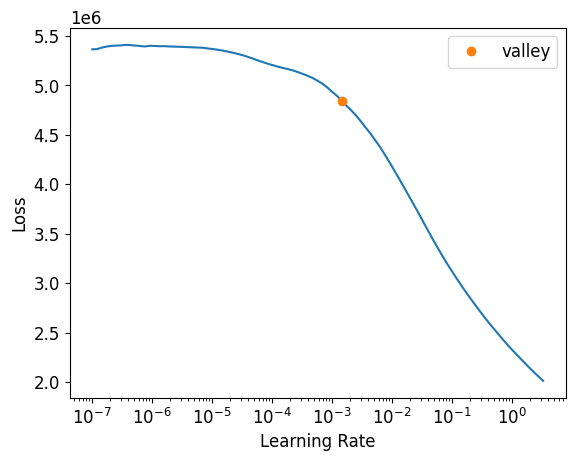

In [23]:
learn.lr_find()

In [53]:
learn.fit_one_cycle(10, 0.001)

epoch,train_loss,valid_loss,time
0,2079697.875000,1174066.250000,00:02
1,966289.062500,503732.718750,00:02
2,334222.812500,761706.187500,00:02
3,108709.593750,41340.359375,00:02
4,82947.289062,43236.332031,00:02
5,59423.398438,50865.929688,00:02
6,39156.992188,24608.750000,00:03
7,26547.982422,22878.740234,00:02
8,25188.546875,22261.623047,00:02
9,21558.587891,21498.896484,00:02


In [54]:
def r_mse(pred, y): return round(math.sqrt(((pred-y)**2).mean()), 6)

In [55]:
preds, targs = learn.get_preds()
r_mse(preds, targs)

146.625033

In [56]:
#
#
#
#
#

In [57]:
def rf(xs, y, n_estimators=40, max_samples=10000,max_features=0.5, min_samples_leaf=5, **kwargs):
  return RandomForestRegressor(n_jobs = -1, n_estimators=n_estimators, max_samples = max_samples, max_features = max_features, min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [58]:
def m_rmse(m, xs, y):
  return r_mse(m.predict(xs), y)

In [59]:
procs_rf = [Categorify, FillMissing]

In [60]:
to_rf = TabularPandas(df_rs, procs_rf, cat_rs, cont_rs, y_names=dep_var, splits=splits)

In [61]:
len(to_rf.train), len(to_rf.valid)

(119199, 29799)

In [62]:
xs_rf, y_rf = to_rf.train.xs, to_rf.train.y
valid_xs_rf, valid_y_rf = to_rf.valid.xs, to_rf.valid.y

In [63]:
m = rf(xs_rf, y_rf)

In [64]:
m_rmse(m, xs_rf, y_rf), m_rmse(m, valid_xs_rf, valid_y_rf)

(85.932807, 94.2891)

In [65]:
preds = np.stack([t.predict(valid_xs_rf) for t in m.estimators_])

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWa

In [66]:
r_mse(preds.mean(0), valid_y_rf)

94.2891

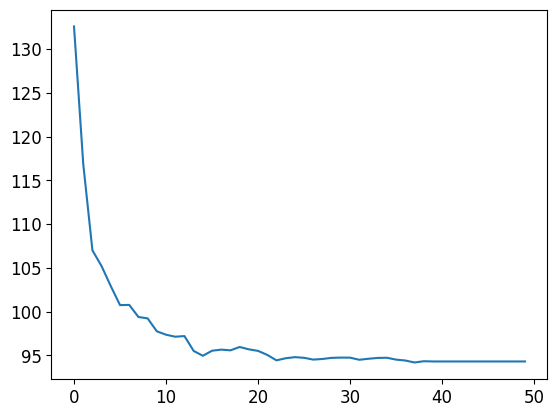

In [67]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y_rf) for i in range(50)])

In [68]:
r_mse(m.oob_prediction_, y_rf)

89.22305

In [69]:
def rf_feat_importance(m, df):
  return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                      ).sort_values('imp', ascending=False)

In [70]:
fi = rf_feat_importance(m, xs_rf)
fi[:10]

,cols,imp
7,accommodates,0.231671
17,bathrooms,0.114120
16,longitude,0.108523
8,bedrooms,0.075824
9,beds,0.064902
15,latitude,0.049392
5,property_type,0.039474
11,minimum_nights,0.039291
6,room_type,0.033928
10,amenities,0.023524


In [71]:
def plot_fi(fi):
  return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

<Axes: ylabel='cols'>

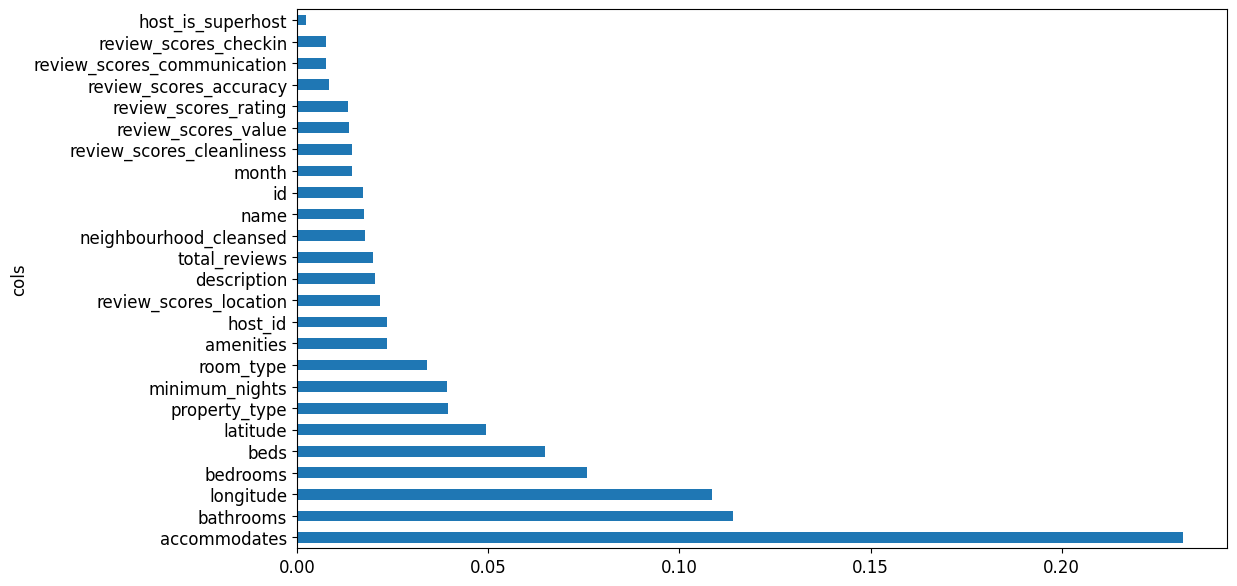

In [72]:
plot_fi(fi[:30])

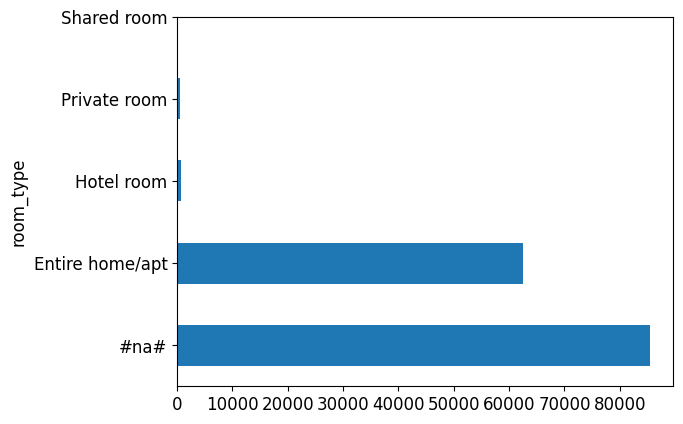

In [73]:
p = df_rs['room_type'].value_counts(sort=False).plot.barh()
c = to_rs.classes['room_type']
plt.yticks(range(len(c)), c);

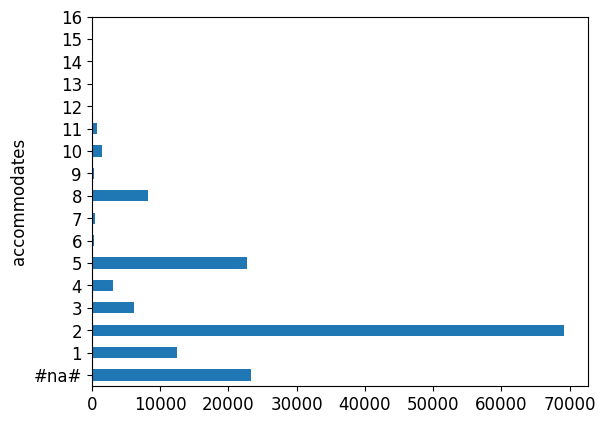

In [74]:
p = df_rs['accommodates'].value_counts(sort=False).plot.barh()
c = to_rs.classes['accommodates']
plt.yticks(range(len(c)), c);

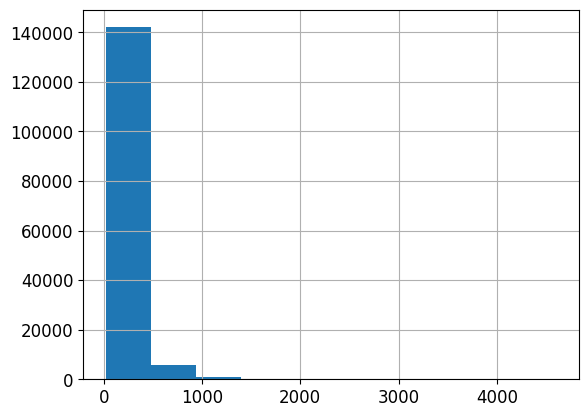

In [75]:
df_rs[dep_var].hist();

In [76]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(8270, 250)
    (1): Embedding(16617, 370)
    (2): Embedding(16245, 365)
    (3): Embedding(3, 3)
    (4): Embedding(219, 33)
    (5): Embedding(58, 16)
    (6): Embedding(5, 4)
    (7): Embedding(17, 8)
    (8): Embedding(14, 7)
    (9): Embedding(21, 9)
    (10): Embedding(18697, 395)
    (11): Embedding(80, 19)
    (12): Embedding(13, 7)
    (13): Embedding(496, 52)
    (14): Embedding(14296, 340)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=1888, out_features=500, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=500, out_features=250, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(250, eps=1e-05, moment

In [77]:
factor = learn.model.embeds
factor

ModuleList(
  (0): Embedding(8270, 250)
  (1): Embedding(16617, 370)
  (2): Embedding(16245, 365)
  (3): Embedding(3, 3)
  (4): Embedding(219, 33)
  (5): Embedding(58, 16)
  (6): Embedding(5, 4)
  (7): Embedding(17, 8)
  (8): Embedding(14, 7)
  (9): Embedding(21, 9)
  (10): Embedding(18697, 395)
  (11): Embedding(80, 19)
  (12): Embedding(13, 7)
  (13): Embedding(496, 52)
  (14): Embedding(14296, 340)
)

In [78]:
df_rs[cat_rs].nunique()

,0
host_id,8274
name,16616
description,16244
host_is_superhost,2
neighbourhood_cleansed,218
property_type,57
room_type,4
accommodates,16
bedrooms,13
beds,20


In [80]:
idx = dls.classes['id'].o2i[np.int64(3866888)]
idx

799

In [83]:
id_embeddings = learn.model.embeds[to_rs.cat_names.index('id')]
id_embeddings

Embedding(14296, 340)

In [85]:
distances = nn.CosineSimilarity(dim=1)(id_embeddings.weight, id_embeddings.weight[idx][None])

most_similar_idx = distances.argsort(descending=True)[1]
most_similar_id = dls.classes['id'][most_similar_idx]

most_similar_id

np.int64(1336223)

In [86]:
display(df_rs[df_rs['id'] == np.int64(3866888)])

,id,host_id,name,description,host_is_superhost,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,minimum_nights,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price,month,price_per_person,log_price,log_price_per_person,total_reviews
695,3866888,17770287,Midtown NYC 2bdrm with patio! 2D,"Private apartment in the center of Manhattan. Apartment has two large bedrooms, kitchen, bathroom,living room and your own private outdoor patio. Couch can converted into a bed as well. Newly purchased furniture and linens. Must be willing to stay for a minimum of 30 days.",1,Midtown,40.74905,-73.9831,Entire rental unit,Entire home/apt,4,1.0,2,0,"Air conditioning, Bed linens, Carbon monoxide alarm, Cooking basics, Dedicated workspace, Dishes and silverware, Extra pillows and blankets, Fire extinguisher, Heating, Hot water, Kitchen, Lockbox, Long term stays allowed, Oven, Patio or balcony, Refrigerator, Self check-in, Smoke alarm, Stove, TV, Wifi",60,4.44,4.61,4.11,4.72,4.72,4.94,4.17,150.0,11,37.5,5.017280,3.650658,19
12496,3866888,17770287,Midtown NYC 2bdrm with patio! 2D,"Private apartment in the center of Manhattan. Apartment has two large bedrooms, kitchen, bathroom,living room and your own private outdoor patio. Couch can converted into a bed as well. Newly purchased furniture and linens. Must be willing to stay for a minimum of 30 days.",1,Midtown,40.74905,-73.9831,Entire rental unit,Entire home/apt,4,1.0,2,0,"Air conditioning, Bed linens, Carbon monoxide alarm, Cooking basics, Dedicated workspace, Dishes and silverware, Extra pillows and blankets, Fire extinguisher, Heating, Hot water, Kitchen, Lockbox, Long term stays allowed, Oven, Patio or balcony, Refrigerator, Self check-in, Smoke alarm, Stove, TV, Wifi",60,4.44,4.61,4.11,4.72,4.72,4.94,4.17,150.0,12,37.5,5.017280,3.650658,19
24459,3866888,17770287,Midtown NYC 2bdrm with patio! 2D,"Private apartment in the center of Manhattan. Apartment has two large bedrooms, kitchen, bathroom,living room and your own private outdoor patio. Couch can converted into a bed as well. Newly purchased furniture and linens. Must be willing to stay for a minimum of 30 days.",1,Midtown,40.74905,-73.9831,Entire rental unit,Entire home/apt,4,1.0,2,0,"Air conditioning, Bed linens, Carbon monoxide alarm, Cooking basics, Dedicated workspace, Dishes and silverware, Extra pillows and blankets, Fire extinguisher, Heating, Hot water, Kitchen, Lockbox, Long term stays allowed, Oven, Patio or balcony, Refrigerator, Self check-in, Smoke alarm, Stove, TV, Wifi",60,4.44,4.61,4.11,4.72,4.72,4.94,4.17,150.0,1,37.5,5.017280,3.650658,19
36475,3866888,17770287,Midtown NYC 2bdrm with patio! 2D,"Private apartment in the center of Manhattan. Apartment has two large bedrooms, kitchen, bathroom,living room and your own private outdoor patio. Couch can converted into a bed as well. Newly purchased furniture and linens. Must be willing to stay for a minimum of 30 days.",0,Midtown,40.74905,-73.9831,Entire rental unit,Entire home/apt,4,1.0,2,0,"Air conditioning, Bed linens, Carbon monoxide alarm, Cooking basics, Dedicated workspace, Dishes and silverware, Extra pillows and blankets, Fire extinguisher, Heating, Hot water, Kitchen, Lockbox, Long term stays allowed, Oven, Patio or balcony, Refrigerator, Self check-in, Smoke alarm, Stove, TV, Wifi",60,4.44,4.61,4.11,4.72,4.72,4.94,4.17,150.0,2,37.5,5.017280,3.650658,19
48783,3866888,17770287,Midtown NYC 2bdrm with patio! 2D,"Private apartment in the center of Manhattan. Apartment has two large bedrooms, kitchen, bathroom,living room and your own private outdoor patio. Couch can converted into a bed as well. Newly purchased furniture and linens. Must be willing to stay for a minimum of 30 days.",0,Midtown,40.74905,-73.9831,Entire rental unit,Entire home/apt,4,1.0,2,0,"Air conditioning, Bed linens, Carbon monoxide 

In [88]:
display(df_rs[df_rs['id'] == most_similar_id])


,id,host_id,name,description,host_is_superhost,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,minimum_nights,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price,month,price_per_person,log_price,log_price_per_person,total_reviews
405,1336223,7245581,Washer/Dryer in Chelsea/Hudson Yards private apt,"This entire private apartment comes with everything you need including your own Washer/Dryer which Michael will give you detergent for and show you how to use! The location could not be more convenient, the LIRR ""Train to the Plane"" & subways are a 5 minute walk.",0,Chelsea,40.749454,-73.996483,Entire rental unit,Entire home/apt,2,1.0,0,1,"Bathtub, Bed linens, Body soap, Carbon monoxide alarm, City skyline view, Cleaning products, Clothing storage: closet and dresser, Coffee maker, Cooking basics, Dedicated workspace, Dining table, Dishes and silverware, Essentials, Extra pillows and blankets, Fire extinguisher, Free dryer In unit, Free street parking, Free washer In unit, Freezer, Gas stove, HDTV with Chromecast, Hulu, standard cable, Hair dryer, Hangers, Heating, Hot water, Hot water kettle, Iron, Kitchen, Lockbox, Long term stays allowed, Microwave, Oven, Paid parking lot off premises, Refrigerator, Room-darkening shade...",120,4.74,4.84,4.71,4.87,4.92,4.74,4.5,98.0,11,49.0,4.595120,3.912023,38
12165,1336223,7245581,Washer/Dryer in Chelsea/Hudson Yards private apt,"This entire private apartment comes with everything you need including your own Washer/Dryer which Michael will give you detergent for and show you how to use! The location could not be more convenient, the LIRR ""Train to the Plane"" & subways are a 5 minute walk.",0,Chelsea,40.749454,-73.996483,Entire rental unit,Entire home/apt,2,1.0,0,1,"Bathtub, Bed linens, Body soap, Carbon monoxide alarm, City skyline view, Cleaning products, Clothing storage: closet and dresser, Coffee maker, Cooking basics, Dedicated workspace, Dining table, Dishes and silverware, Essentials, Extra pillows and blankets, Fire extinguisher, Free dryer In unit, Free street parking, Free washer In unit, Freezer, Gas stove, HDTV with Chromecast, Hulu, standard cable, Hair dryer, Hangers, Heating, Hot water, Hot water kettle, Iron, Kitchen, Lockbox, Long term stays allowed, Microwave, Oven, Paid parking lot off premises, Refrigerator, Room-darkening shade...",90,4.74,4.84,4.71,4.87,4.92,4.74,4.5,98.0,12,49.0,4.595120,3.912023,38
24166,1336223,7245581,Washer/Dryer in Chelsea/Hudson Yards private apt,"This entire private apartment comes with everything you need including your own Washer/Dryer which Michael will give you detergent for and show you how to use! The location could not be more convenient, the LIRR ""Train to the Plane"" & subways are a 5 minute walk.",0,Chelsea,40.749454,-73.996483,Entire rental unit,Entire home/apt,2,1.0,0,1,"Bathtub, Bed linens, Body soap, Carbon monoxide alarm, City skyline view, Cleaning products, Clothing storage: closet and dresser, Coffee maker, Cooking basics, Dedicated workspace, Dining table, Dishes and silverware, Essentials, Extra pillows and blankets, Fire extinguisher, Free dryer In unit, Free street parking, Free washer In unit, Freezer, Gas stove, HDTV with Chromecast, Hulu, standard cable, Hair dryer, Hangers, Heating, Hot water, Hot water kettle, Iron, Kitchen, Lockbox, Long term stays allowed, Microwave, Oven, Paid parking lot off premises, Refrigerator, Room-darkening shade...",75,4.74,4.84,4.71,4.87,4.92,4.74,4.5,98.0,1,49.0,4.595120,3.912023,38
36194,1336223,7245581,Washer/Dryer in Chelsea/Hudson Yards private apt,"This entire private apartment comes with everything you need including your own Washer/Dryer which Michael will give you detergent for and show you how to use! The location could not be more convenient, the LIRR ""Train to the Plane"" & subways are a 5 minute 